In [8]:
from astropy.modeling import models, fitting
from dendrocat import RadioSource
from astropy.io import fits
from spectral_cube import SpectralCube
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import sys
import importlib
from astropy.wcs import WCS
from scipy import interpolate
import pandas as pd
import sympy as syp
from astropy import units as u
import radio_beam
from astropy.table import Table
from radio_beam import Beam
from astropy import coordinates
from astropy import wcs
from astropy.nddata.utils import Cutout2D
#from dendrocat.aperture import Ellipse
from matplotlib.patches import Rectangle, Ellipse
import regions
from scipy.optimize import curve_fit
from regions import EllipseAnnulusSkyRegion, EllipseAnnulusPixelRegion

import Paths.Paths as paths
Path = paths.filepaths()






b3_id   b6_id  b3_xpix b3_ypix b6_xpix b6_ypix      b3_xsky            b3_ysky            b6_xsky            b6_ysky              b3_afwhm               b3_bfwhm               b3_pa               b6_afwhm               b6_bfwhm               b6_pa        is_matched is_overlap      flux_peak_b3           flux_peak_b6             alpha               BBtemp       isincore_b3cov isincore_b6cov isincore_b3fov isincore_b6fov        flux_b3             flux_lowerr_b3         flux_upperr_b3        fitted_major_b3     fitted_major_upperr_b3 fitted_major_lowerr_b3    fitted_minor_b3     fitted_minor_upperr_b3 fitted_minor_lowerr_b3  deconvolved_major_b3   deconvolved_minor_b3  deconvolved_major_upperr_b3 deconvolved_minor_upperr_b3 deconvolved_major_lowerr_b3 deconvolved_minor_lowerr_b3        flux_b6             flux_lowerr_b6         flux_upperr_b6        fitted_major_b6     fitted_major_upperr_b6 fitted_major_lowerr_b6    fitted_minor_b6     fitted_minor_upperr_b6 fitted_minor_lowerr_b6  deco

"\nax1.vlines(w51e_b6_min_size,0,1,color='cyan',lw=2,ls='dashed')\nax1.vlines(w51e_b3_min_size,0,1,color='peru',lw=2,ls='dashed')\nax1.vlines(w51n_b6_min_size,0,1,color='b',lw=2,ls='dashed')\nax1.vlines(w51n_b3_min_size,0,1,color='orange',lw=2,ls='dashed')\n"

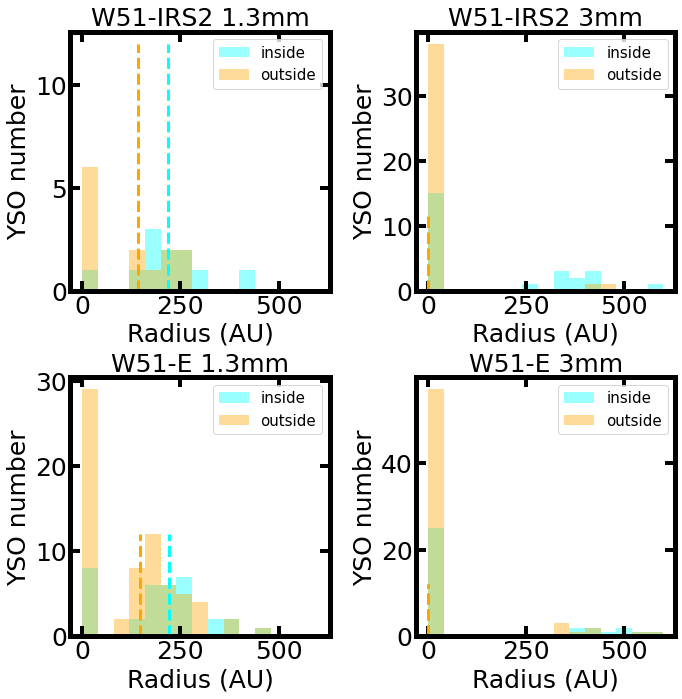

In [9]:
from astropy.table import Table
import matplotlib as mpl
import astropy.units as u
import astropy.constants as c
from lifelines import KaplanMeierFitter

plt.rcParams['axes.labelsize']=25
plt.rcParams['xtick.labelsize']=25
plt.rcParams['ytick.labelsize']=25
plt.rcParams['axes.titlesize']=25
mpl.rcParams['axes.linewidth'] = 5
mpl.rcParams['xtick.major.size'] = 10
mpl.rcParams['xtick.major.width'] = 4
mpl.rcParams['xtick.minor.size'] = 5
mpl.rcParams['xtick.minor.width'] = 2
mpl.rcParams['ytick.major.size'] = 10
mpl.rcParams['ytick.major.width'] = 4
mpl.rcParams['ytick.minor.size'] = 5
mpl.rcParams['ytick.minor.width'] = 2
params = {"xtick.top": True, "ytick.right": True, "xtick.direction": "in", "ytick.direction": "in"}
plt.rcParams.update(params)


w51e_b3_flux_fits = Table.read(Path.w51e_b3_flux)
w51e_b6_flux_fits = Table.read(Path.w51e_b6_flux)
w51n_b3_flux_fits = Table.read(Path.w51n_b3_flux)
w51n_b6_flux_fits = Table.read(Path.w51n_b6_flux)
w51e_b6_flux_conv_fits = Table.read(Path.w51e_b6_conv_flux)
w51n_b6_flux_conv_fits = Table.read(Path.w51n_b6_conv_flux)

def get_max_size(size_major, size_minor):
    sizearr = []
    idxarr = []
    for i in range(len(size_major)):
        if size_major[i]>size_minor[i]:
            sizearr.append(size_major[i])
        else:
            sizearr.append(size_minor[i])
            idxarr.append(i)
    return np.array(sizearr), np.array(idxarr)

def get_radius(fitsfile, band='b6', index=None, dist_kpc = 5.41):
 
    fits = Table.read(fitsfile)
    major = fits['deconvolved_major_%s'%band]
    minor = fits['deconvolved_minor_%s'%band]
    if index is None:
        index = np.arange(len(major))
    
    avg_size = np.sqrt(major * minor)[index]
    avg_size = np.max((major[index],minor[index]))
    radius_au = avg_size * np.pi/180 * dist_kpc *1000*206264.806 *2/2.355
    return radius_au


w51e_catalog = Table.read(Path.w51e_dendro_matched_catalog,format='fits')
w51n_catalog = Table.read(Path.w51n_dendro_matched_catalog,format='fits')
w51e_catalog.pprint_all()
#YSO index for indicating whether they are inside core boundary or not
isincore_w51e_b3 = w51e_catalog['isinsidecore_b3fov'] 
isincore_w51n_b3 = w51n_catalog['isinsidecore_b3fov'] 
isoutcore_w51e_b3 = ~w51e_catalog['isinsidecore_b3fov'] 
isoutcore_w51n_b3 = ~w51n_catalog['isinsidecore_b3fov'] 


    
# For b6, need to combine isincore index with isoverlap index
isincore_w51e_b6 = np.intersect1d(np.where(w51e_catalog['isinsidecore_b3fov']), np.where(w51e_catalog['is_overlap'])) 
isincore_w51n_b6 = np.intersect1d(np.where(w51n_catalog['isinsidecore_b3fov']), np.where(w51n_catalog['is_overlap'])) 
isoutcore_w51e_b6 = np.intersect1d(np.where(~w51e_catalog['isinsidecore_b3fov']), np.where(w51e_catalog['is_overlap'])) 
isoutcore_w51n_b6 = np.intersect1d(np.where(~w51n_catalog['isinsidecore_b3fov']), np.where(w51n_catalog['is_overlap'])) 


si_w51e = w51e_catalog['alpha']
si_w51n = w51n_catalog['alpha']


w51e_b3_major = w51e_b3_flux_fits['deconvolved_major']
w51e_b6_major = w51e_b6_flux_fits['deconvolved_major']
w51n_b3_major = w51n_b3_flux_fits['deconvolved_major']
w51n_b6_major = w51n_b6_flux_fits['deconvolved_major']
w51e_b3_minor = w51e_b3_flux_fits['deconvolved_minor']
w51e_b6_minor = w51e_b6_flux_fits['deconvolved_minor']
w51n_b3_minor = w51n_b3_flux_fits['deconvolved_minor']
w51n_b6_minor = w51n_b6_flux_fits['deconvolved_minor']

isoverlap_w51e = w51e_catalog['is_overlap']
isoverlap_w51n = w51n_catalog['is_overlap']

fig = plt.figure(figsize=(12,12))
ax1 = fig.add_axes([0.1,0.1,0.3,0.3])
ax2 = fig.add_axes([0.5,0.1,0.3,0.3])
ax3 = fig.add_axes([0.1,0.5,0.3,0.3])
ax4 = fig.add_axes([0.5,0.5,0.3,0.3])

print(isincore_w51e_b6)

w51e_b3_max_size,w51e_b3_idx = get_max_size(w51e_b3_major, w51e_b3_minor)
w51e_b6_max_size,w51e_b6_idx = get_max_size(w51e_b6_major[isoverlap_w51e], w51e_b6_major[isoverlap_w51e]) 
w51n_b3_max_size,w51n_b3_idx = get_max_size(w51n_b3_major, w51n_b3_minor)
w51n_b6_max_size,w51n_b6_idx = get_max_size(w51n_b6_major[isoverlap_w51n], w51n_b6_minor[isoverlap_w51n])

w51e_b3_max_size_au = w51e_b3_max_size * np.pi/180 * 5.41*1000*206265
w51e_b6_max_size_au = w51e_b6_max_size * np.pi/180 * 5.41*1000*206265
w51n_b3_max_size_au = w51n_b3_max_size * np.pi/180 * 5.1*1000*206265
w51n_b6_max_size_au = w51n_b6_max_size * np.pi/180 * 5.1*1000*206265


w51e_b6_rad_isincore = w51e_b6_max_size_au[isincore_w51e_b6]
w51e_b6_rad_isoutcore = w51e_b6_max_size_au[isoutcore_w51e_b6]

w51e_b3_rad_isincore = w51e_b3_max_size_au[isincore_w51e_b3]
w51e_b3_rad_isoutcore = w51e_b3_max_size_au[isoutcore_w51e_b3]

w51n_b6_rad_isincore = w51n_b6_max_size_au[isincore_w51n_b6]
w51n_b6_rad_isoutcore = w51n_b6_max_size_au[isoutcore_w51n_b6]

w51n_b3_rad_isincore = w51n_b3_max_size_au[isincore_w51n_b3]
w51n_b3_rad_isoutcore = w51n_b3_max_size_au[isoutcore_w51n_b3]

#w51e_b6_rad[~w51e_b6_unresolved] = w51e_b6_min_size*2/2.355
#w51e_b3_rad[~w51e_b3_unresolved] = w51e_b3_min_size*2/2.355
#w51n_b6_rad[~w51n_b6_unresolved] = w51n_b6_min_size*2/2.355
#w51n_b3_rad[~w51n_b3_unresolved] = w51n_b3_min_size*2/2.355

bins = np.linspace(0,600,16)


ax1.hist(w51e_b6_rad_isincore, bins=bins, label='inside', color='cyan', alpha=0.4)
ax1.hist(w51e_b6_rad_isoutcore, bins=bins, label='outside', color='orange', alpha=0.4)
ax1.vlines(np.median(w51e_b6_rad_isincore[w51e_b6_rad_isincore<1e5]),0,12, color='cyan',lw=3, ls='dashed')
ax1.vlines(np.median(w51e_b6_rad_isoutcore[w51e_b6_rad_isoutcore<1e5]),0,12, color='orange',lw=3, ls='dashed')
print(w51e_b6_rad_isincore)
print(w51e_b6_rad_isoutcore)
ax1.set_title('W51-E 1.3mm')
ax1.set_xlabel('Radius (AU)')
ax1.set_ylabel('YSO number')
ax1.legend(fontsize=15)

ax2.hist(w51e_b3_rad_isincore, bins=bins, label='inside', color='cyan', alpha=0.4)
ax2.hist(w51e_b3_rad_isoutcore, bins=bins, label='outside', color='orange', alpha=0.4)
ax2.vlines(np.median(w51e_b3_rad_isincore[w51e_b3_rad_isincore<1e5]),0,12, color='cyan',lw=3, ls='dashed')
ax2.vlines(np.median(w51e_b3_rad_isoutcore[w51e_b3_rad_isoutcore<1e5]),0,12, color='orange',lw=3, ls='dashed')
ax2.set_title('W51-E 3mm')
ax2.set_xlabel('Radius (AU)')
ax2.set_ylabel('YSO number')
ax2.legend(fontsize=15)

ax3.hist(w51n_b6_rad_isincore, bins=bins, label='inside', color='cyan', alpha=0.4)
ax3.hist(w51n_b6_rad_isoutcore, bins=bins, label='outside', color='orange', alpha=0.4)
ax3.vlines(np.median(w51n_b6_rad_isincore[w51n_b6_rad_isincore<1e5]),0,12, color='cyan',lw=3, ls='dashed')
ax3.vlines(np.median(w51n_b6_rad_isoutcore[w51n_b6_rad_isoutcore<1e5]),0,12, color='orange',lw=3, ls='dashed')
ax3.set_title('W51-IRS2 1.3mm')
ax3.set_xlabel('Radius (AU)')
ax3.set_ylabel('YSO number')
ax3.legend(fontsize=15)

ax4.hist(w51n_b3_rad_isincore, bins=bins, label='inside', color='cyan', alpha=0.4)
ax4.hist(w51n_b3_rad_isoutcore, bins=bins, label='outside', color='orange', alpha=0.4)
ax4.vlines(np.median(w51n_b3_rad_isincore[w51n_b3_rad_isincore<1e5]),0,12, color='cyan',lw=3, ls='dashed')
ax4.vlines(np.median(w51n_b3_rad_isoutcore[w51n_b3_rad_isoutcore<1e5]),0,12, color='orange',lw=3, ls='dashed')
ax4.set_title('W51-IRS2 3mm')
ax4.set_xlabel('Radius (AU)')
ax4.set_ylabel('YSO number')
ax4.legend(fontsize=15)


"""
ax1.vlines(w51e_b6_min_size,0,1,color='cyan',lw=2,ls='dashed')
ax1.vlines(w51e_b3_min_size,0,1,color='peru',lw=2,ls='dashed')
ax1.vlines(w51n_b6_min_size,0,1,color='b',lw=2,ls='dashed')
ax1.vlines(w51n_b3_min_size,0,1,color='orange',lw=2,ls='dashed')
"""




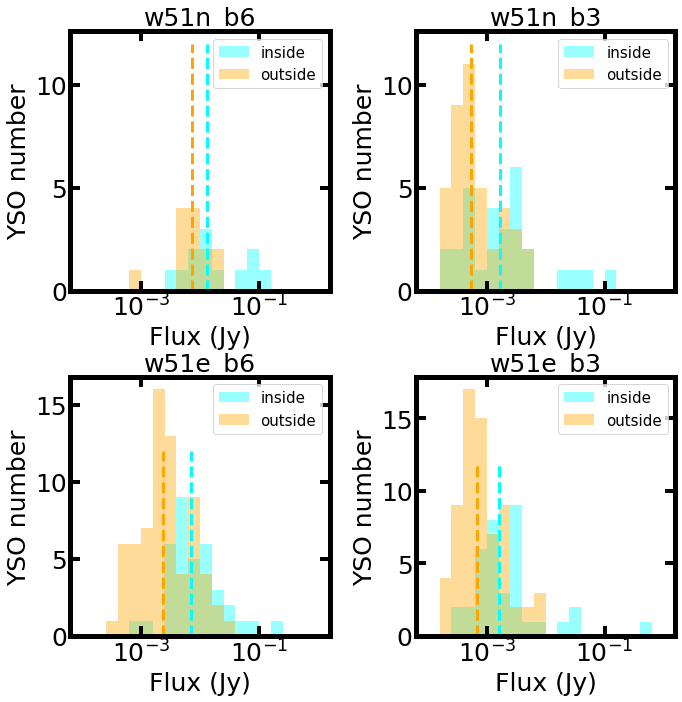

In [10]:
def kappa(nu, nu0=271.1*u.GHz, kappa0=0.0114*u.cm**2*u.g**-1, beta=1.75):
    """
    Compute the opacity $\kappa$ given a reference frequency (or wavelength)
    and a power law governing the opacity as a fuction of frequency:
    $$ \kappa = \kappa_0 \left(\\frac{\\nu}{\\nu_0}\\right)^{\\beta} $$
    The default kappa=0.0114 at 271.1 GHz comes from extrapolating the
    Ossenkopf & Henning 1994 opacities for the thin-ice-mantle, 10^6 year model
    anchored at 1.0 mm with an assumed beta of 1.75.
    Parameters
    ----------
    nu: astropy.Quantity [u.spectral() equivalent]
        The frequency at which to evaluate kappa
    nu0: astropy.Quantity [u.spectral() equivalent]
        The reference frequency at which $\kappa$ is defined
    kappa0: astropy.Quantity [cm^2/g]
        The dust opacity per gram of H2 along the line of sight.  Because of
        the H2 conversion, this factor implicitly includes a dust to gas ratio
        (usually assumed 100)
    beta: float
        The power-law index governing kappa as a function of nu
    """
    return (kappa0*(nu.to(u.GHz,u.spectral())/nu0.to(u.GHz,u.spectral()))**(beta)).to(u.cm**2/u.g)
def get_mass(flux, kappa, freq, temp=50*u.K, dist=5.41*u.kpc, verbose=False):
    BB = 2 *np.pi * c.h * freq**3 / (c.c**2) / (np.e**(c.h*freq/(c.k_B*temp)) - 1)
    mass = flux.to(u.Jy) * dist**2 / BB.to(u.Jy) / kappa
    
    return mass.to(u.Msun)

fig = plt.figure(figsize=(12,12))
ax1 = fig.add_axes([0.1,0.1,0.3,0.3])
ax2 = fig.add_axes([0.5,0.1,0.3,0.3])
ax3 = fig.add_axes([0.1,0.5,0.3,0.3])
ax4 = fig.add_axes([0.5,0.5,0.3,0.3])


w51e_b6_flux_isincore = w51e_catalog['flux_b6'][isincore_w51e_b6] 
w51e_b6_flux_isoutcore = w51e_catalog['flux_b6'][isoutcore_w51e_b6] 

w51e_b3_flux_isincore = w51e_catalog['flux_b3'][isincore_w51e_b3] 
w51e_b3_flux_isoutcore = w51e_catalog['flux_b3'][isoutcore_w51e_b3] 

w51n_b6_flux_isincore = w51n_catalog['flux_b6'][isincore_w51n_b6] 
w51n_b6_flux_isoutcore = w51n_catalog['flux_b6'][isoutcore_w51n_b6] 

w51n_b3_flux_isincore = w51n_catalog['flux_b3'][isincore_w51n_b3] 
w51n_b3_flux_isoutcore = w51n_catalog['flux_b3'][isoutcore_w51n_b3] 


bins = np.logspace(-4,0,21)



ax1.hist(w51e_b6_flux_isincore[w51e_b6_flux_isincore>0], bins=bins, label='inside', color='cyan', alpha=0.4)
ax1.hist(w51e_b6_flux_isoutcore[w51e_b6_flux_isoutcore>0], bins=bins, label='outside', color='orange', alpha=0.4)
ax1.vlines(np.median(w51e_b6_flux_isincore[w51e_b6_flux_isincore>0]),0,12, color='cyan',lw=3, ls='dashed')
ax1.vlines(np.median(w51e_b6_flux_isoutcore[w51e_b6_flux_isoutcore>0]),0,12, color='orange',lw=3, ls='dashed')

ax1.set_title('w51e_b6')
ax1.set_xlabel('Flux (Jy)')
ax1.set_ylabel('YSO number')
ax1.legend(fontsize=15)
ax1.set_xscale('log')

ax2.hist(w51e_b3_flux_isincore[w51e_b3_flux_isincore>0], bins=bins, label='inside', color='cyan', alpha=0.4)
ax2.hist(w51e_b3_flux_isoutcore[w51e_b3_flux_isoutcore>0], bins=bins, label='outside', color='orange', alpha=0.4)
ax2.vlines(np.median(w51e_b3_flux_isincore[w51e_b3_flux_isincore>0]),0,12, color='cyan',lw=3, ls='dashed')
ax2.vlines(np.median(w51e_b3_flux_isoutcore[w51e_b3_flux_isoutcore>0]),0,12, color='orange',lw=3, ls='dashed')
ax2.set_title('w51e_b3')
ax2.set_xlabel('Flux (Jy)')
ax2.set_ylabel('YSO number')
ax2.legend(fontsize=15)
ax2.set_xscale('log')

ax3.hist(w51n_b6_flux_isincore[w51n_b6_flux_isincore>0], bins=bins, label='inside', color='cyan', alpha=0.4)
ax3.hist(w51n_b6_flux_isoutcore[w51n_b6_flux_isoutcore>0], bins=bins, label='outside', color='orange', alpha=0.4)
ax3.vlines(np.median(w51n_b6_flux_isincore[w51n_b6_flux_isincore>0]),0,12, color='cyan',lw=3, ls='dashed')
ax3.vlines(np.median(w51n_b6_flux_isoutcore[w51n_b6_flux_isoutcore>0]),0,12, color='orange',lw=3, ls='dashed')
ax3.set_title('w51n_b6')
ax3.set_xlabel('Flux (Jy)')
ax3.set_ylabel('YSO number')
ax3.legend(fontsize=15)
ax3.set_xscale('log')

ax4.hist(w51n_b3_flux_isincore[w51n_b3_flux_isincore>0], bins=bins, label='inside', color='cyan', alpha=0.4)
ax4.hist(w51n_b3_flux_isoutcore[w51n_b3_flux_isoutcore>0], bins=bins, label='outside', color='orange', alpha=0.4)
ax4.vlines(np.median(w51n_b3_flux_isincore[w51n_b3_flux_isincore>0]),0,12, color='cyan',lw=3, ls='dashed')
ax4.vlines(np.median(w51n_b3_flux_isoutcore[w51n_b3_flux_isoutcore>0]),0,12, color='orange',lw=3, ls='dashed')
ax4.set_title('w51n_b3')
ax4.set_xlabel('Flux (Jy)')
ax4.set_ylabel('YSO number')
ax4.legend(fontsize=15)
ax4.set_xscale('log')



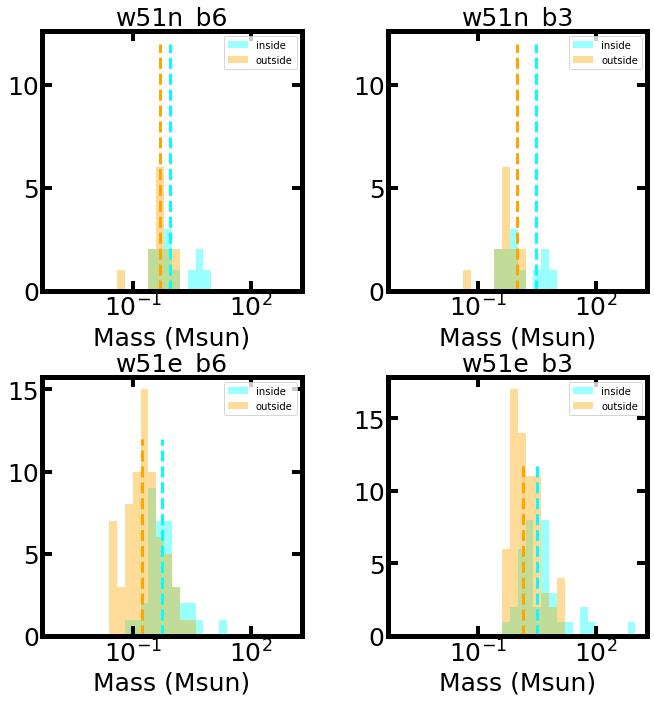

In [11]:
massbins = np.logspace(-3,3,31)
b3freq = 92982346121.91989*u.Hz
b6freq = 226691598706.70853*u.Hz
b3kappa = kappa(b3freq)
b6kappa = kappa(b6freq)
w51e_b6_mass_isincore = get_mass(w51e_b6_flux_isincore[w51e_b6_flux_isincore>0], b6kappa,  b6freq)   
w51e_b6_mass_isoutcore = get_mass(w51e_b6_flux_isoutcore[w51e_b6_flux_isoutcore>0], b6kappa,  b6freq)   

w51e_b3_mass_isincore = get_mass(w51e_b3_flux_isincore[w51e_b3_flux_isincore>0], b3kappa,  b3freq)   
w51e_b3_mass_isoutcore = get_mass(w51e_b3_flux_isoutcore[w51e_b3_flux_isoutcore>0], b3kappa,  b3freq) 

w51n_b6_mass_isincore = get_mass(w51n_b6_flux_isincore[w51n_b6_flux_isincore>0], b6kappa,  b6freq,dist=5.1*u.kpc)   
w51n_b6_mass_isoutcore = get_mass(w51n_b6_flux_isoutcore[w51n_b6_flux_isoutcore>0], b6kappa,  b6freq,dist=5.1*u.kpc)   

w51n_b3_mass_isincore = get_mass(w51n_b3_flux_isincore[w51n_b3_flux_isincore>0], b3kappa,  b3freq,dist=5.1*u.kpc)   
w51n_b3_mass_isoutcore = get_mass(w51n_b3_flux_isoutcore[w51n_b3_flux_isoutcore>0], b3kappa,  b3freq,dist=5.1*u.kpc) 

fig = plt.figure(figsize=(12,12))
ax1 = fig.add_axes([0.1,0.1,0.3,0.3])
ax2 = fig.add_axes([0.5,0.1,0.3,0.3])
ax3 = fig.add_axes([0.1,0.5,0.3,0.3])
ax4 = fig.add_axes([0.5,0.5,0.3,0.3])
ax1.hist(w51e_b6_mass_isincore.value, bins=massbins, label='inside', color='cyan', alpha=0.4)
ax1.hist(w51e_b6_mass_isoutcore.value, bins=massbins, label='outside', color='orange', alpha=0.4)
ax1.vlines(np.median(w51e_b6_mass_isincore.value),0,12, color='cyan',lw=3, ls='dashed')
ax1.vlines(np.median(w51e_b6_mass_isoutcore.value),0,12, color='orange',lw=3, ls='dashed')
ax2.hist(w51e_b3_mass_isincore.value, bins=massbins, label='inside', color='cyan', alpha=0.4)
ax2.hist(w51e_b3_mass_isoutcore.value, bins=massbins, label='outside', color='orange', alpha=0.4)
ax2.vlines(np.median(w51e_b3_mass_isincore.value),0,12, color='cyan',lw=3, ls='dashed')
ax2.vlines(np.median(w51e_b3_mass_isoutcore.value),0,12, color='orange',lw=3, ls='dashed')
ax3.hist(w51n_b6_mass_isincore.value, bins=massbins, label='inside', color='cyan', alpha=0.4)
ax3.hist(w51n_b6_mass_isoutcore.value, bins=massbins, label='outside', color='orange', alpha=0.4)
ax3.vlines(np.median(w51n_b6_mass_isincore.value),0,12, color='cyan',lw=3, ls='dashed')
ax3.vlines(np.median(w51n_b6_mass_isoutcore.value),0,12, color='orange',lw=3, ls='dashed')
ax4.hist(w51n_b6_mass_isincore.value, bins=massbins, label='inside', color='cyan', alpha=0.4)
ax4.hist(w51n_b6_mass_isoutcore.value, bins=massbins, label='outside', color='orange', alpha=0.4)
ax4.vlines(np.median(w51n_b3_mass_isincore.value),0,12, color='cyan',lw=3, ls='dashed')
ax4.vlines(np.median(w51n_b3_mass_isoutcore.value),0,12, color='orange',lw=3, ls='dashed')

ax1.set_xlabel('Mass (Msun)')
ax2.set_xlabel('Mass (Msun)')
ax3.set_xlabel('Mass (Msun)')
ax4.set_xlabel('Mass (Msun)')
ax1.set_title('w51e_b6')
ax2.set_title('w51e_b3')
ax3.set_title('w51n_b6')
ax4.set_title('w51n_b3')

ax1.set_xscale('log')
ax2.set_xscale('log')
ax3.set_xscale('log')
ax4.set_xscale('log')
ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()

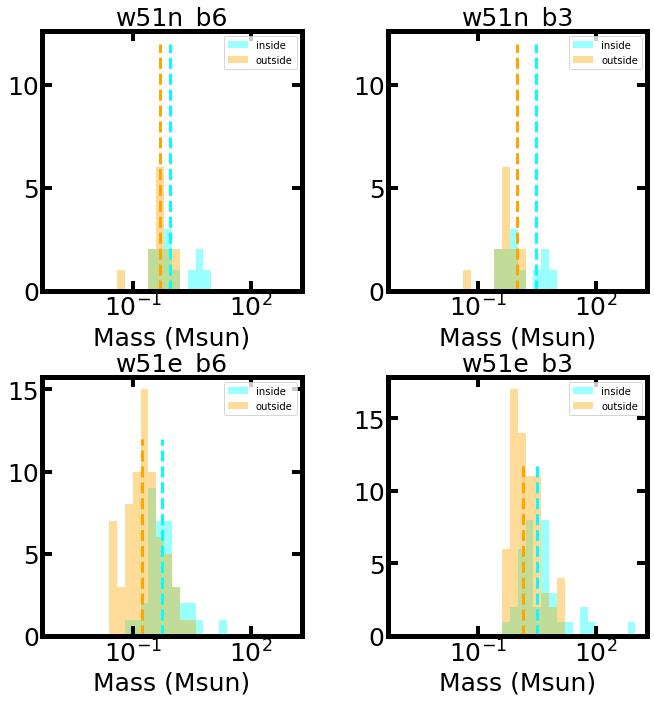

In [12]:
massbins = np.logspace(-3,3,31)
b3freq = 92982346121.91989*u.Hz
b6freq = 226691598706.70853*u.Hz
b3kappa = kappa(b3freq)
b6kappa = kappa(b6freq)
w51e_b6_mass_isincore = get_mass(w51e_b6_flux_isincore[w51e_b6_flux_isincore>0], b6kappa,  b6freq)   
w51e_b6_mass_isoutcore = get_mass(w51e_b6_flux_isoutcore[w51e_b6_flux_isoutcore>0], b6kappa,  b6freq)   

w51e_b3_mass_isincore = get_mass(w51e_b3_flux_isincore[w51e_b3_flux_isincore>0], b3kappa,  b3freq)   
w51e_b3_mass_isoutcore = get_mass(w51e_b3_flux_isoutcore[w51e_b3_flux_isoutcore>0], b3kappa,  b3freq) 

w51n_b6_mass_isincore = get_mass(w51n_b6_flux_isincore[w51n_b6_flux_isincore>0], b6kappa,  b6freq,dist=5.1*u.kpc)   
w51n_b6_mass_isoutcore = get_mass(w51n_b6_flux_isoutcore[w51n_b6_flux_isoutcore>0], b6kappa,  b6freq,dist=5.1*u.kpc)   

w51n_b3_mass_isincore = get_mass(w51n_b3_flux_isincore[w51n_b3_flux_isincore>0], b3kappa,  b3freq,dist=5.1*u.kpc)   
w51n_b3_mass_isoutcore = get_mass(w51n_b3_flux_isoutcore[w51n_b3_flux_isoutcore>0], b3kappa,  b3freq,dist=5.1*u.kpc) 

fig = plt.figure(figsize=(12,12))
ax1 = fig.add_axes([0.1,0.1,0.3,0.3])
ax2 = fig.add_axes([0.5,0.1,0.3,0.3])
ax3 = fig.add_axes([0.1,0.5,0.3,0.3])
ax4 = fig.add_axes([0.5,0.5,0.3,0.3])
ax1.hist(w51e_b6_mass_isincore.value, bins=massbins, label='inside', color='cyan', alpha=0.4)
ax1.hist(w51e_b6_mass_isoutcore.value, bins=massbins, label='outside', color='orange', alpha=0.4)
ax1.vlines(np.median(w51e_b6_mass_isincore.value),0,12, color='cyan',lw=3, ls='dashed')
ax1.vlines(np.median(w51e_b6_mass_isoutcore.value),0,12, color='orange',lw=3, ls='dashed')
ax2.hist(w51e_b3_mass_isincore.value, bins=massbins, label='inside', color='cyan', alpha=0.4)
ax2.hist(w51e_b3_mass_isoutcore.value, bins=massbins, label='outside', color='orange', alpha=0.4)
ax2.vlines(np.median(w51e_b3_mass_isincore.value),0,12, color='cyan',lw=3, ls='dashed')
ax2.vlines(np.median(w51e_b3_mass_isoutcore.value),0,12, color='orange',lw=3, ls='dashed')
ax3.hist(w51n_b6_mass_isincore.value, bins=massbins, label='inside', color='cyan', alpha=0.4)
ax3.hist(w51n_b6_mass_isoutcore.value, bins=massbins, label='outside', color='orange', alpha=0.4)
ax3.vlines(np.median(w51n_b6_mass_isincore.value),0,12, color='cyan',lw=3, ls='dashed')
ax3.vlines(np.median(w51n_b6_mass_isoutcore.value),0,12, color='orange',lw=3, ls='dashed')
ax4.hist(w51n_b6_mass_isincore.value, bins=massbins, label='inside', color='cyan', alpha=0.4)
ax4.hist(w51n_b6_mass_isoutcore.value, bins=massbins, label='outside', color='orange', alpha=0.4)
ax4.vlines(np.median(w51n_b3_mass_isincore.value),0,12, color='cyan',lw=3, ls='dashed')
ax4.vlines(np.median(w51n_b3_mass_isoutcore.value),0,12, color='orange',lw=3, ls='dashed')

ax1.set_xlabel('Mass (Msun)')
ax2.set_xlabel('Mass (Msun)')
ax3.set_xlabel('Mass (Msun)')
ax4.set_xlabel('Mass (Msun)')
ax1.set_title('w51e_b6')
ax2.set_title('w51e_b3')
ax3.set_title('w51n_b6')
ax4.set_title('w51n_b3')

ax1.set_xscale('log')
ax2.set_xscale('log')
ax3.set_xscale('log')
ax4.set_xscale('log')
ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()

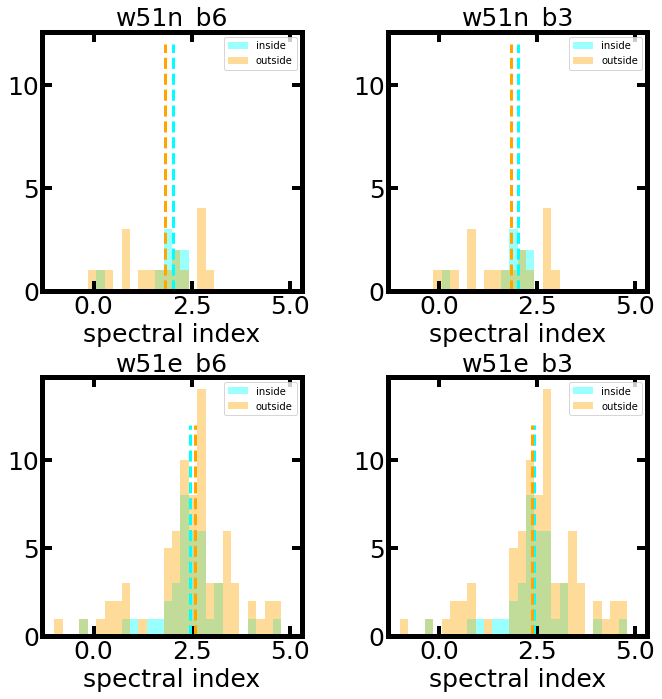

In [13]:
bins = np.linspace(-1,5,29)
fig = plt.figure(figsize=(12,12))
ax1 = fig.add_axes([0.1,0.1,0.3,0.3])
ax2 = fig.add_axes([0.5,0.1,0.3,0.3])
ax3 = fig.add_axes([0.1,0.5,0.3,0.3])
ax4 = fig.add_axes([0.5,0.5,0.3,0.3])
ax1.hist(si_w51e[isincore_w51e_b6], bins=bins, label='inside', color='cyan', alpha=0.4)
ax1.hist(si_w51e[isoutcore_w51e_b6], bins=bins, label='outside', color='orange', alpha=0.4)
ax1.vlines(np.median(si_w51e[isincore_w51e_b6]),0,12, color='cyan',lw=3, ls='dashed')
ax1.vlines(np.median(si_w51e[isoutcore_w51e_b6]),0,12, color='orange',lw=3, ls='dashed')
ax2.hist(si_w51e[isincore_w51e_b3], bins=bins, label='inside', color='cyan', alpha=0.4)
ax2.hist(si_w51e[isoutcore_w51e_b3], bins=bins, label='outside', color='orange', alpha=0.4)
ax2.vlines(np.median(si_w51e[isincore_w51e_b3]),0,12, color='cyan',lw=3, ls='dashed')
ax2.vlines(np.median(si_w51e[isoutcore_w51e_b3]),0,12, color='orange',lw=3, ls='dashed')
ax3.hist(si_w51n[isincore_w51n_b6], bins=bins, label='inside', color='cyan', alpha=0.4)
ax3.hist(si_w51n[isoutcore_w51n_b6], bins=bins, label='outside', color='orange', alpha=0.4)
ax3.vlines(np.median(si_w51n[isincore_w51n_b6]),0,12, color='cyan',lw=3, ls='dashed')
ax3.vlines(np.median(si_w51n[isoutcore_w51n_b6]),0,12, color='orange',lw=3, ls='dashed')
ax4.hist(si_w51n[isincore_w51n_b6], bins=bins, label='inside', color='cyan', alpha=0.4)
ax4.hist(si_w51n[isoutcore_w51n_b6], bins=bins, label='outside', color='orange', alpha=0.4)
ax4.vlines(np.median(si_w51n[isincore_w51n_b6]),0,12, color='cyan',lw=3, ls='dashed')
ax4.vlines(np.median(si_w51n[isoutcore_w51n_b6]),0,12, color='orange',lw=3, ls='dashed')

ax1.set_xlabel('spectral index')
ax2.set_xlabel('spectral index')
ax3.set_xlabel('spectral index')
ax4.set_xlabel('spectral index')
ax1.set_title('w51e_b6')
ax2.set_title('w51e_b3')
ax3.set_title('w51n_b6')
ax4.set_title('w51n_b3')

#ax1.set_xscale('log')
#ax2.set_xscale('log')
#ax3.set_xscale('log')
#ax4.set_xscale('log')
ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()

ho [256.45877428   0.           0.         239.44572242 260.60895972
 203.19390354   0.         351.85687361 143.76885703 618.54821491
 141.31053615   0.           0.         256.94042966 234.44878255
 870.32510134 449.91746879 399.23363799 164.47138586 199.37013405
 256.24073598 199.32980491 243.38869571 196.63174094 241.78659806
 258.52335881 181.54890409 325.40705541 197.61137358 233.0409351
 234.23853655   0.           0.                  nan 211.02145349
   0.         365.65638434]
hoho [155.64220688 218.84211995   0.           0.           0.
 171.25656347 214.72245218 196.95962818   0.         273.64523985
   0.         263.60923135 149.55358313 252.10642277 388.63430675
   0.         194.96942176 295.23582957 260.04789574 263.94932912
 187.08570546 299.48576656 228.85568568 167.04211235   0.
 459.55371297 119.12413876 392.22033295   0.         175.28083703
 143.44435215   0.         194.00922813 164.09253915 210.02883447
   0.           0.           0.           0.             

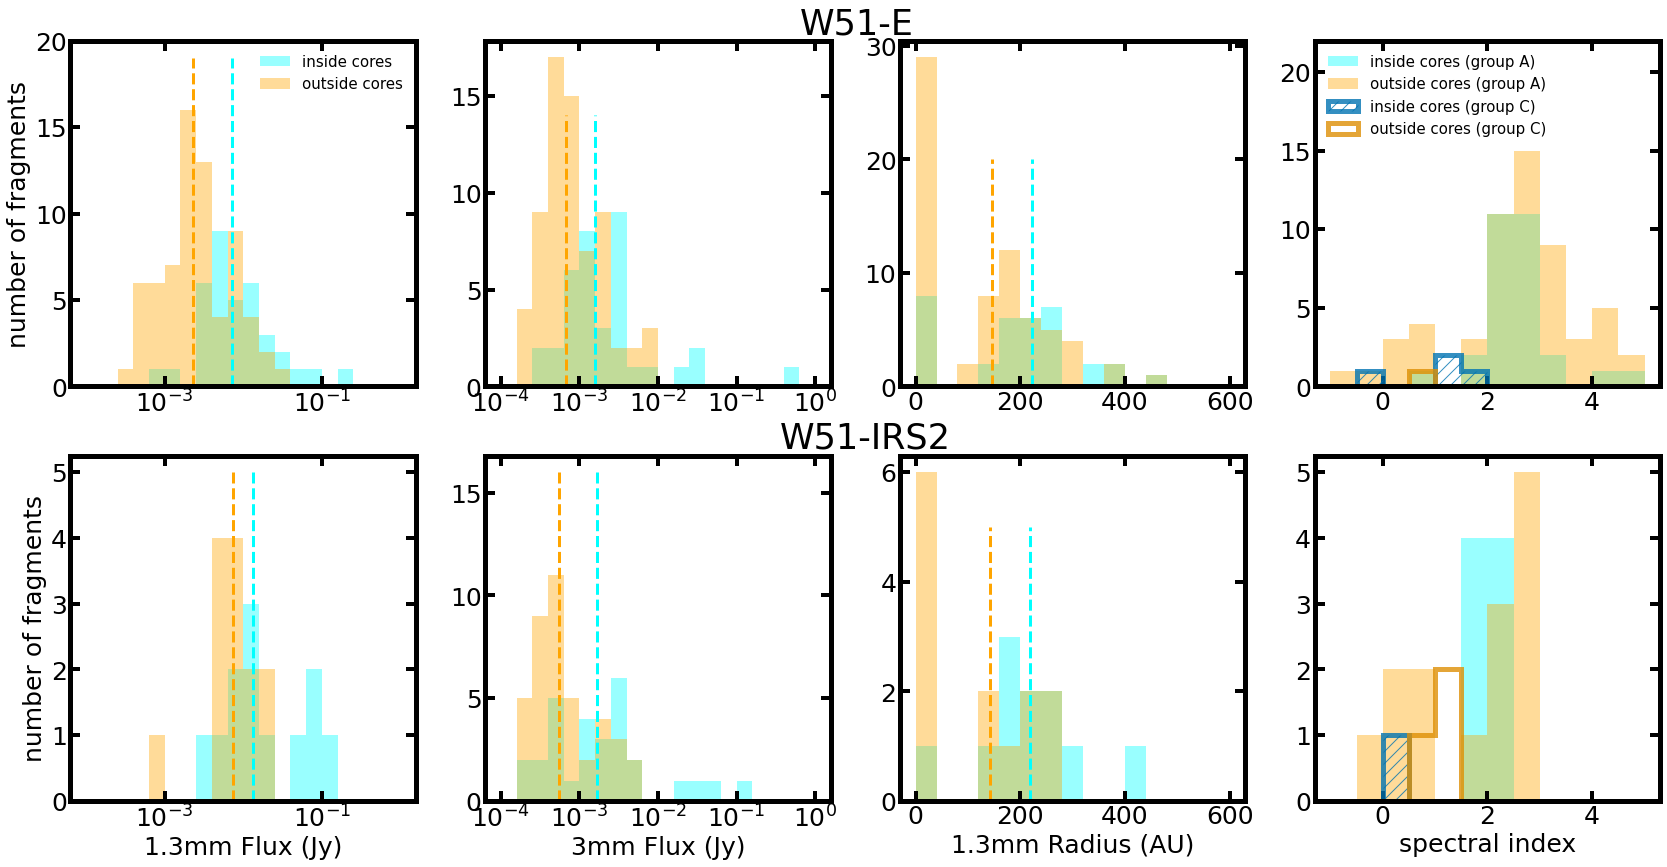

In [14]:
import seaborn as sns
fig = plt.figure(figsize=(24,12))
ax5 = fig.add_axes([0.05,0.08,0.2,0.4])
ax6 = fig.add_axes([0.29,0.08,0.2,0.4])
ax7 = fig.add_axes([0.53,0.08,0.2,0.4])
ax8 = fig.add_axes([0.77,0.08,0.2,0.4])

ax1 = fig.add_axes([0.05,0.56,0.2,0.4])
ax2 = fig.add_axes([0.29,0.56,0.2,0.4])
ax3 = fig.add_axes([0.53,0.56,0.2,0.4])
ax4 = fig.add_axes([0.77,0.56,0.2,0.4])


bins = np.logspace(-4,0,21)
#plt.subtitle('W51-E')
plt.figtext(0.51, 0.5, 'W51-IRS2', ha='center', va='center',fontsize=35)
plt.figtext(0.505, 0.98, 'W51-E', ha='center', va='center',fontsize=35)


ax1.hist(w51e_b6_flux_isincore[w51e_b6_flux_isincore>0], bins=bins, label='inside cores', color='cyan', alpha=0.4)
ax1.hist(w51e_b6_flux_isoutcore[w51e_b6_flux_isoutcore>0], bins=bins, label='outside cores', color='orange', alpha=0.4)
ax1.vlines(np.median(w51e_b6_flux_isincore[w51e_b6_flux_isincore>0]),0,19, color='cyan',lw=3, ls='dashed')
ax1.vlines(np.median(w51e_b6_flux_isoutcore[w51e_b6_flux_isoutcore>0]),0,19, color='orange',lw=3, ls='dashed')

#ax1.set_title('W51e_b6')
ax1.set_xticks([1e-4,1e-3,1e-2,1e-1,1])
ax5.set_xlabel('1.3mm Flux (Jy)')
ax1.set_yticks([0,5,10,15,20])
ax1.set_ylabel('number of fragments')
ax1.legend(fontsize=15, frameon=False)
ax1.set_xscale('log')


ax5.hist(w51n_b6_flux_isincore[w51n_b6_flux_isincore>0], bins=bins, label='inside', color='cyan', alpha=0.4)
ax5.hist(w51n_b6_flux_isoutcore[w51n_b6_flux_isoutcore>0], bins=bins, label='outside', color='orange', alpha=0.4)
ax5.vlines(np.median(w51n_b6_flux_isincore[w51n_b6_flux_isincore>0]),0,5, color='cyan',lw=3, ls='dashed')
ax5.vlines(np.median(w51n_b6_flux_isoutcore[w51n_b6_flux_isoutcore>0]),0,5, color='orange',lw=3, ls='dashed')
ax5.set_xticks([1e-4,1e-3,1e-2,1e-1,1])

#ax5.set_title('w51n_b6')
#ax5.set_xlabel('1.3mm Flux (Jy)')
ax5.set_ylabel('number of fragments')
#ax5.legend(fontsize=15)
ax5.set_xscale('log')


ax2.hist(w51e_b3_flux_isincore[w51e_b3_flux_isincore>0], bins=bins, label='inside', color='cyan', alpha=0.4)
ax2.hist(w51e_b3_flux_isoutcore[w51e_b3_flux_isoutcore>0], bins=bins, label='outside', color='orange', alpha=0.4)
ax2.vlines(np.median(w51e_b3_flux_isincore[w51e_b3_flux_isincore>0]),0,14, color='cyan',lw=3, ls='dashed')
ax2.vlines(np.median(w51e_b3_flux_isoutcore[w51e_b3_flux_isoutcore>0]),0,14, color='orange',lw=3, ls='dashed')
ax2.set_yticks([0,5,10,15])
#ax2.set_title('w51e_b3')
ax6.set_xlabel('3mm Flux (Jy)')
#ax2.set_ylabel('YSO number')
#ax2.legend(fontsize=15)
ax2.set_xscale('log')
ax2.set_xticks([1e-4,1e-3,1e-2,1e-1,1])


ax6.hist(w51n_b3_flux_isincore[w51n_b3_flux_isincore>0], bins=bins, label='inside', color='cyan', alpha=0.4)
ax6.hist(w51n_b3_flux_isoutcore[w51n_b3_flux_isoutcore>0], bins=bins, label='outside', color='orange', alpha=0.4)
ax6.vlines(np.median(w51n_b3_flux_isincore[w51n_b3_flux_isincore>0]),0,16, color='cyan',lw=3, ls='dashed')
ax6.vlines(np.median(w51n_b3_flux_isoutcore[w51n_b3_flux_isoutcore>0]),0,16, color='orange',lw=3, ls='dashed')
#ax4.set_title('w51n_b3')
#ax6.set_xlabel('3mm Flux (Jy)')
#ax4.set_ylabel('YSO number')
#ax4.legend(fontsize=15)
ax6.set_xscale('log')
ax6.set_xticks([1e-4,1e-3,1e-2,1e-1,1])

bins = np.linspace(0,600,16)
print('ho',w51e_b6_rad_isincore)
print('hoho',w51e_b6_rad_isoutcore)

ax3.hist(w51e_b6_rad_isincore, bins=bins, label='inside', color='cyan', alpha=0.4)
ax3.hist(w51e_b6_rad_isoutcore, bins=bins, label='outside', color='orange', alpha=0.4)
ax3.vlines(np.median(w51e_b6_rad_isincore[w51e_b6_rad_isincore<1e5]),0,20, color='cyan',lw=3, ls='dashed')
w51e_b6_rad_isoutcore_finite = w51e_b6_rad_isoutcore[np.isfinite(w51e_b6_rad_isoutcore)]
ax3.vlines(np.median(w51e_b6_rad_isoutcore_finite[w51e_b6_rad_isoutcore_finite<1e5]),0,20, color='orange',lw=3, ls='dashed')
print(np.median(w51e_b6_rad_isincore[w51e_b6_rad_isincore<1e5]))
print(np.median(w51e_b6_rad_isoutcore[w51e_b6_rad_isoutcore<1e5]))
#w51e_b6_rad_isoutcore[(w51e_b6_rad_isoutcore<1e5) & (np.isfinite(w51e_b6_rad_isoutcore))].pprint()
#ax3.set_title('W51-E 1.3mm')
#ax3.set_ylabel('YSO number')
#ax1.legend(fontsize=15)
bins = np.linspace(0,600,16)

ax7.hist(w51n_b6_rad_isincore, bins=bins, label='inside', color='cyan', alpha=0.4)
ax7.hist(w51n_b6_rad_isoutcore, bins=bins, label='outside', color='orange', alpha=0.4)
ax7.vlines(np.median(w51n_b6_rad_isincore[w51n_b6_rad_isincore<1e5]),0,5, color='cyan',lw=3, ls='dashed')
ax7.vlines(np.median(w51n_b6_rad_isoutcore[w51n_b6_rad_isoutcore<1e5]),0,5, color='orange',lw=3, ls='dashed')
#ax7.set_title('W51-IRS2 1.3mm')
#ax7.set_xlabel('1.3mm Radius (AU)')
#ax7.set_ylabel('YSO number')
ax7.set_xlabel('1.3mm Radius (AU)')

bins = np.linspace(-1,5,13)
si_w51e_incore = si_w51e[isincore_w51e_b6]
si_w51e_outcore = si_w51e[isoutcore_w51e_b6]
si_w51n_incore = si_w51n[isincore_w51n_b6]
si_w51n_outcore = si_w51n[isoutcore_w51n_b6]


group_w51e = w51e_catalog['group']
group_w51n = w51n_catalog['group']
group_w51e_incore = group_w51e[isincore_w51e_b6]
group_w51e_outcore = group_w51e[isoutcore_w51e_b6]
group_w51n_incore = group_w51n[isincore_w51n_b6]
group_w51n_outcore = group_w51n[isoutcore_w51n_b6]

cmap = sns.color_palette("colorblind")

ax4.hist(si_w51e_incore[group_w51e_incore==0], bins=bins, label=r'inside cores (group A)', color='cyan', alpha=0.4)
ax4.hist(si_w51e_outcore[group_w51e_outcore==0], bins=bins, label=r'outside cores (group A)', color='orange', alpha=0.4)
ax4.hist(si_w51e_incore[group_w51e_incore==2], bins=bins,  label=r'inside cores (group C)',facecolor='none',edgecolor=cmap[0], histtype='step', alpha=0.8,lw=5,hatch='//')
ax4.hist(si_w51e_outcore[group_w51e_outcore==2], bins=bins,  label=r'outside cores (group C)',facecolor='none',edgecolor=cmap[1], histtype='step', alpha=0.8,lw=5)
#ax4.vlines(np.median(si_w51e[isincore_w51e_b6]),0,14, color='cyan',lw=3, ls='dashed')
#ax4.vlines(np.median(si_w51e[isoutcore_w51e_b6]),0,14, color='orange',lw=3, ls='dashed')

ax8.hist(si_w51n_incore[group_w51n_incore==0], bins=bins, label='inside', color='cyan', alpha=0.4)
ax8.hist(si_w51n_outcore[group_w51n_outcore==0], bins=bins, label='outside', color='orange', alpha=0.4)
ax8.hist(si_w51n_incore[group_w51n_incore==2], bins=bins,  facecolor='none',edgecolor=cmap[0], histtype='step', alpha=0.8,lw=5,hatch='//')
ax8.hist(si_w51n_outcore[group_w51n_outcore==2], bins=bins,  facecolor='none',edgecolor=cmap[1], histtype='step', alpha=0.8,lw=5)
#ax8.vlines(np.median(si_w51n[isincore_w51n_b6]),0,5, color='cyan',lw=3, ls='dashed')
#ax8.vlines(np.median(si_w51n[isoutcore_w51n_b6]),0,5, color='orange',lw=3, ls='dashed')
print(len(si_w51e_incore[si_w51e_incore>1.7]))
print(len(si_w51e_outcore[si_w51e_outcore>1.7]))
print(len(si_w51e_incore[si_w51e_incore<1.7]))
print(len(si_w51e_outcore[si_w51e_outcore<1.7]))
print(len(si_w51n_incore[si_w51n_incore>1.7]))
print(len(si_w51n_outcore[si_w51n_outcore>1.7]))
print(len(si_w51n_incore[si_w51n_incore<1.7]))
print(len(si_w51n_outcore[si_w51n_outcore<1.7]))
print(np.where(w51n_b6_flux_isoutcore<2e-2)[0])
print(isoutcore_w51n_b6)
print(w51n_b6_flux_isoutcore)
intersecind = np.intersect1d(np.where(w51e_b6_flux_isoutcore<2e-3)[0], isoutcore_w51e_b6)
print(si_w51e[intersecind])
ax4.legend(fontsize=15,loc='upper left', frameon=False)
ax8.set_xlabel('spectral index')
ax4.set_ylim(0,22)
#ax8.set_xlabel('spectral index')
plt.savefig('ysocomparison.png')